# Brain atrophy as Potential Biomarker of Alzheimer's disease in Aged Sample

(STAT 201) Group: 24


# Introduction

Dementia is a progressive condition associated with brain atrophy and aging, involving widespread neuropsychological deficits that significantly hinder daily activities (Reuben et. al, 2010). Our project focuses on Alzheimer's disease (AD), the most common form of dementia. Unfortunately, AD has neither definitive diagnosis nor cure (Ash, 2007). Consequently, the early detection and prevention of AD by examining signs such as shrinkage in brain matter is essential for healthy aging.

The current paper hypothesizes that patients with Alzheimer’s Disease will have significantly lower mean total brain volume compared to non-Alzheimer’s disease patients above the age of 60. We will analyze the dataset Dementia Classification: Compare Classifiers from Kaggle.com (Deepak N, 2018), estimating the population mean difference and use  the variability of the sampling distribution before hypothesis testing. Our null-hypothesis states that there will be no difference between the two groups. If we observe a significantly lower brain volume, similar neuro-imaging techniques may be applicable for detecting early signs of Alzheimer's disease in clinical settings in the future.

The current dataset originally comes from the MRI Open Access Series of Imaging Studies (OASIS-2, 2009) which collects patient information using magnetic resonance imaging to investigate possible biomarkers of AD. This dataset consists of 15 variables and 373 rows, sampling from 150 participants of age 60-96 longitudinally. It classifies whether participants have dementia or not. This table includes description of the variables:


| Variables | Description | Variables | Description |
| --- | ----------- | ---- | ----- |
| Subject ID | ID for each Participant | EDUC | Higher level of education attained (years) |
| MRI ID | MRI scan ID | SES | Socioeconomic Status| 
| Group | Non- demented, demented, or converted from non-demented to demented | MMSE | Mini-mental state examination score (0 = worst to 30 = worst) |
| Visit | Number of visits to the laboratory | CDR | Clinical dementia rating (0 = no dementia to 2 = moderate Alzheimer's) | 
|MR Delay | Delay between each visit | eTIV | Estimated total intracranial volume ($cm^3$) |
|Sex | Male / female (M/F) | nWBV | Normalized whole brain volume (unitless) | 
| Dominant Hand | Right / left handed | ASF | Scaling factor correcting for head size (%) | 
| Age | In years | | |

Table 1.1: Description of data set Variables



$µ_a$ = Mean normalized whole brain volume (nWBV) patients exhibiting signs of Alzheimer’s disease

$µ_n$ = Mean normalized whole brain volume (nWBV) of patients not exhibiting signs of Alzheimer’s disease

$H_0$: $µ_n - µ_a = 0$

$H_A$: $µ_n - µ_a > 0$


## Methods and Results

### Preliminary Exploratory Analysis

In [ ]:
# Load the required libraries
library(dplyr)
library(readr)
library(tidyverse)
library(cowplot)
library(datateachr)
library(infer)
library(repr)
library(digest)
library(gridExtra)
library(broom)

# Read the CSV file into a data frame

data_alzheimer <- read.csv("https://raw.githubusercontent.com/yuwangy/alzheimer_analysis/main/oasis_longitudinal.csv")

# Preview the data frame
head(data_alzheimer)


,Subject.ID,MRI.ID,Group,Visit,MR.Delay,M.F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>
1,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2,27,0.0,1987,0.696,0.883
2,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2,30,0.0,2004,0.681,0.876
3,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NA,23,0.5,1678,0.736,1.046
4,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NA,28,0.5,1738,0.713,1.010
5,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NA,22,0.5,1698,0.701,1.034
6,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3,28,0.0,1215,0.710,1.444



Table 1.2: Data Frame



In [ ]:
# filter for demented and nondemented patients
# select alzheimer type and brain volume columns from alzheimer dataset
# remove missing NA values from nWBV

# Demented: diagnosed with dementia
# Nondemented: not diagnosed with dementia, may be used as a control group in the study

nwbv1 <- data_alzheimer |>
filter(Group == "Demented" | Group == "Nondemented") |>
filter(!is.na(nWBV)) |>
select(Subject.ID, Group, nWBV)

head(nwbv1)

nrow(nwbv1)

nwbv1|>
group_by(Subject.ID)|>
summarize(mean(nWBV)) |>
nrow()

,Subject.ID,Group,nWBV
,<chr>,<chr>,<dbl>
1,OAS2_0001,Nondemented,0.696
2,OAS2_0001,Nondemented,0.681
3,OAS2_0002,Demented,0.736
4,OAS2_0002,Demented,0.713
5,OAS2_0002,Demented,0.701
6,OAS2_0004,Nondemented,0.710


[1] 336

[1] 136

Table 1.3 : Filtered data set for demented and non-demented patients 

In [ ]:
# Because we have longitudinal data of multiple scan for the same patient, we compute the average nWBV over different laboratory scans.

nwbv <- nwbv1 |>
group_by(Group, Subject.ID) |>
summarize(nWBV = mean(nWBV))

head(nwbv)
nrow(nwbv)

`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.


Group,Subject.ID,nWBV
<chr>,<chr>,<dbl>
Demented,OAS2_0002,0.7166667
Demented,OAS2_0007,0.7283333
Demented,OAS2_0009,0.7985000
Demented,OAS2_0010,0.7605000
Demented,OAS2_0014,0.6965000
Demented,OAS2_0016,0.6530000


[1] 136

Table 1.4: Preview of average nWBV estimate across participants

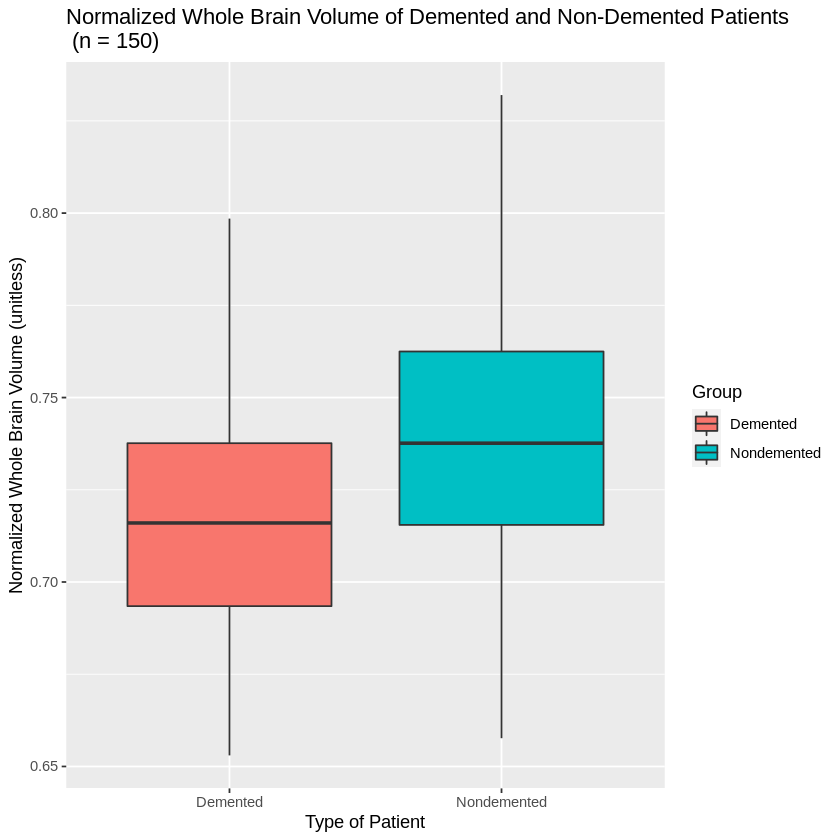

In [ ]:
# Create boxplot of the nWBV for the Demented and Non-Demented Groups to visualize sample difference

boxplot_nwbv <- nwbv |>
ggplot() +
geom_boxplot(aes(x = Group, y = nWBV, fill = Group)) +
xlab("Type of Patient") + 
ylab("Normalized Whole Brain Volume (unitless)") +
ggtitle("Normalized Whole Brain Volume of Demented and Non-Demented Patients \n (n = 150)")

boxplot_nwbv

Figure 1.0: Comparing Normalized Whole Brain Volumne (nWBV) measure

> Comparing Normalized Whole Brain Volumne (nWBV) measure, the above boxplot suggests that the Nondemented group has a higher median line than the Demented group. This suggests that the current sample of healthy participants tend to have greater brain volume than those who exhibits signs of Alzheimer's disease.

### Summary Descriptive of the Observed Data of Current Sample

In [ ]:
# Calculate descriptive statistic for dataset

nWBV_descriptive <- nwbv |>
                group_by(Group) |>
                summarize(mean = mean(nWBV),
                         sample_size = n(), 
                         sd = sd(nWBV))

nWBV_descriptive

Group,mean,sample_size,sd
<chr>,<dbl>,<int>,<dbl>
Demented,0.7175107,64,0.03172100
Nondemented,0.7404854,72,0.03811823


Table 1.5:  Descriptive statistic for data set 

In [ ]:
sample_diff_in_mean <- nWBV_descriptive |> 
summarize(sample_diff_in_mean = mean[2] - mean[1])

sample_diff_in_mean

sample_diff_in_mean
<dbl>
0.02297474


Table 1.6: Sample difference in mean 

> In the current dataset, participants in the Demented group has a mean measure of nWBV of 0.716 and a standard deviation of 0.032 ($n_a = 146$). Participants in the Nondemented group has a mean measure of nWBV of 0.741 and a standard deviation of 0.038 ($n_n = 190$). The difference in means ($µ_n - µ_a$) observed in this data set is 0.0246, suggesting slightly higher brain volume in healthy seniors in this sample.  

### Using Bootstrap to Estimate the Sampling Distribution of Each Group

In [ ]:
# generate bootstrapping samples using the infer package,
# not necessary but showing multiple ways to get similar statistics.

#set seed for bootstrapping
set.seed(2365)

bootstrap_demented_infer <- nwbv |>
filter(Group == "Demented") |>
specify(response = nWBV) |>
generate(reps = 2000, type = "bootstrap") |>
calculate(stat = "mean")

se_bootstrap_demented_infer <- bootstrap_demented_infer |>
summarise(Demented_mean = mean(stat),
          standard_error = sd(stat))

se_bootstrap_demented_infer


Demented_mean,standard_error
<dbl>,<dbl>
0.7174911,0.003871272


Table 1.7: Demeneted mean and standard error

In [ ]:
bootstrap_nondemented_infer <- nwbv |>
filter(Group == "Nondemented") |>
specify(response = nWBV) |>
generate(reps = 2000, type = "bootstrap") |>
calculate(stat = "mean")

se_bootstrap_nondemented_infer <- bootstrap_nondemented_infer |>
summarise(Nondemented_mean = mean(stat),
          standard_error = sd(stat))

se_bootstrap_nondemented_infer

Nondemented_mean,standard_error
<dbl>,<dbl>
0.7404034,0.004435305


Table 1.8: NonDemeneted mean and standard error

> Using the `infer` package to perform the bootstrap (reps = 2000), the bootstrap resample shows that the standard error of the sampling distribution of the Demented group is 0.003, and that of the Nondemented group is 0.003. Both bootstrap means of the Demented ($\bar X_a = 0.716$) and Nondemented ($\bar X_n = 0.741$) group, which converge at the original sample's mean.

### Bootstrap the Difference in Mean -- The Parameter of Interest

In [ ]:
# find the observed difference in means using the infer package

obs_diff_in_means <-
                nwbv |>
                specify(formula = nWBV ~ Group) |>
                calculate(stat = "diff in means", order = c("Nondemented", "Demented")) 

obs_diff_in_means

stat
<dbl>
0.02297474


Table 1.9: Oberserved Difference in mean calculated using the infer package 

### Bootstrap Distribution of Difference in Means to Estimate Sampling Distribution & Sampling Variability

In [ ]:
#set seed
set.seed(5830) 

# find the bootstrapping distribution for the difference in means:

nwbv_diff_in_means_bootstrap <- nwbv |>
                            specify(formula = nWBV ~ Group) |>
                            generate(reps = 2000, type = "bootstrap") |>
                            calculate(stat = "diff in means", order = c("Nondemented", "Demented"))

head(nwbv_diff_in_means_bootstrap)


replicate,stat
<int>,<dbl>
1,0.02884483
2,0.02363775
3,0.02052829
4,0.02197534
5,0.02296906
6,0.01920900


Table 1.10: bootstrap resample 

In [ ]:
nwbv_diff_in_means_bootstrap |>
summarize(se = sd(stat))


se
<dbl>
0.005956585


Table 1.11: Standard error of the bootstrap resample 

> The bootstrap resample of the difference in mean between Nondemented and Demented has a standard error of 0.006.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



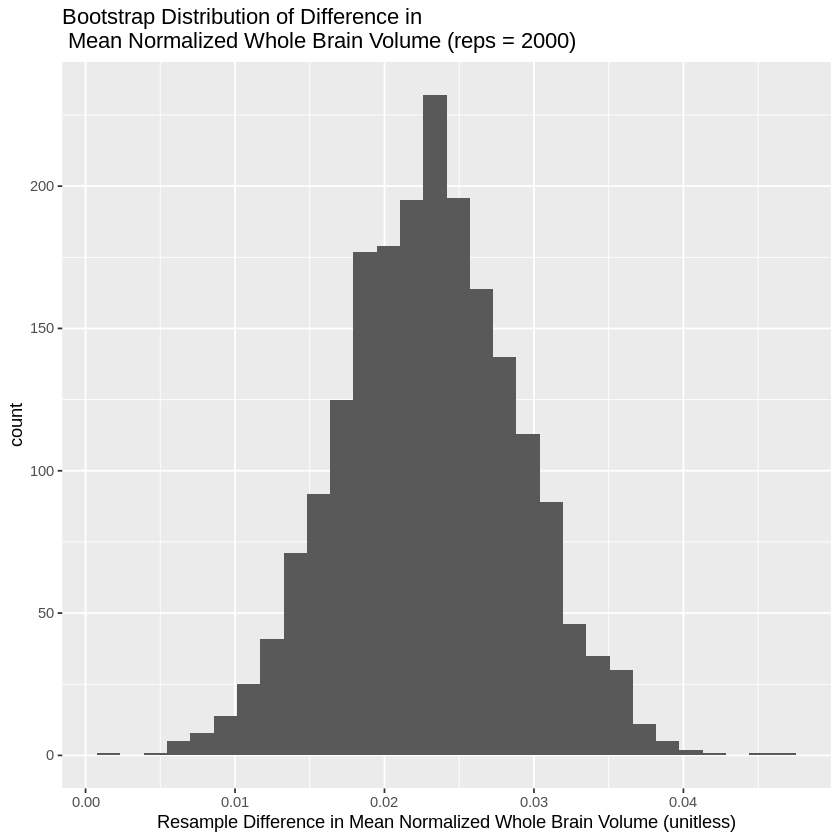

In [ ]:
nwbv_diff_in_means_boot_dis <- nwbv_diff_in_means_bootstrap |>
        ggplot(aes(x = stat)) + 
        geom_histogram() +
        labs(x = "Resample Difference in Mean Normalized Whole Brain Volume (unitless)", 
             title = "Bootstrap Distribution of Difference in \n Mean Normalized Whole Brain Volume (reps = 2000)")

nwbv_diff_in_means_boot_dis

### Parameter Estimation using Bootstrap & Confidence Interval
Given our 2 independent's group samples, we bootstrapped the difference of means for the Demented and Nondemented group. As such, we can construct a confidence interval using 95% confidence level (based on convention in the field) to estimate the range of plausible values of difference in means in the true population:

In [ ]:
# find the 95% confidence interval of the difference in means

diff_in_means_ci <- nwbv_diff_in_means_bootstrap |>
                get_confidence_interval(level = 0.95, type = "percentile")

diff_in_means_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.01150707,0.03516066


table 1.12:  finding the 95% confidence interval 

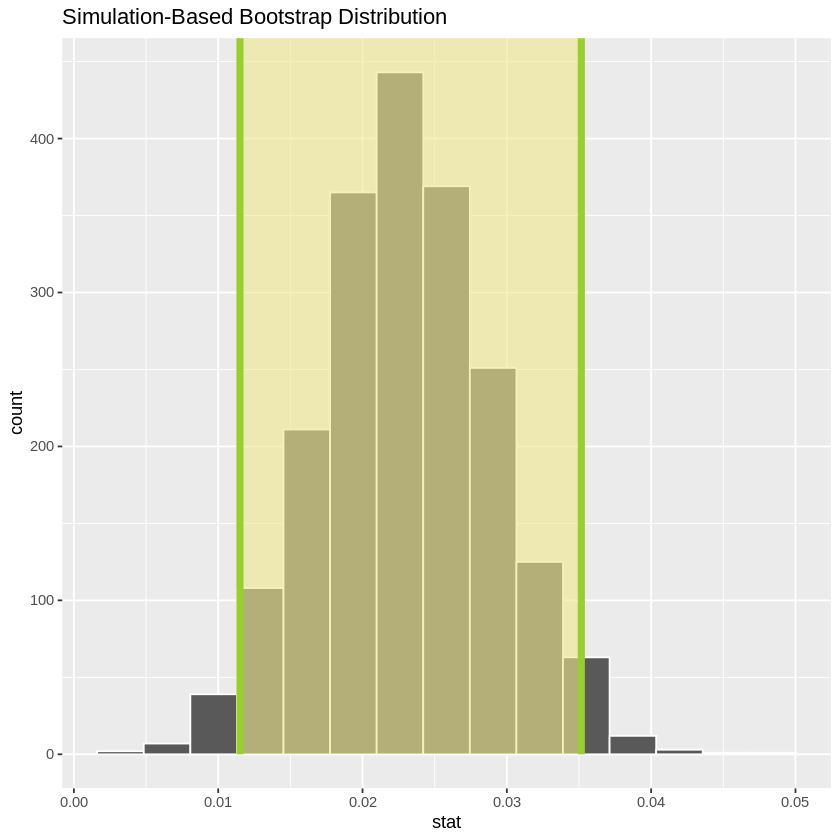

In [ ]:
visualize(nwbv_diff_in_means_bootstrap) + 
  shade_confidence_interval(endpoints = diff_in_means_ci, fill = "khaki", color = "yellowgreen")

Figure 1.1: Visualization of nWBV bootstrap resample 

> Our bootstrap resample has 95%CI (0.0170, 0.032). This 95%CI indicates that over repeated samples, 95% of confidence intervals constructed in the same manner will capture the true parameter $µ_n - µ_a$. 

## Methods and Results: 

From the previous boxplot alone, although we see that the Nondemented group ($mean_n = 0.741$) shows slightly higher nWBV measures than the Demented group ($mean_a = 0.716$) with an observed difference in means ($µ_n - µ_a$) of 0.0246. However, we lack statistical evidence about whether this higher measure of brain volume in the non-demented group is meaningful different. 

To answer our question with greater statistical rigor, we conduct hypothesis testing to analyze the statistical significance of the apparent higher brain volume measure observed in the Nondemented group compared to the Demented group in this data set. We hypothesize that patients of age 65 - 96 without signs of Alzheimer's disease exhibit lower brain volume compared to Alzheimer's patients. 

Because we have no access to the population of all Alzheimer's patients (age ≥ 65), we first perform the asymptotic Independence Group's t-test to accurately use the sample standard deviation ($s$) in place of the population standard deviation ($\sigma$). We also perform an additional test to model a null distribution through permutation resampling. Based on convention in the field, we  set the significance level to ⍺ = 0.05 (one-tailed) for the hypothesis testing and confidence interval.


#### Asymptotic: Independence Group's t-test

In [ ]:
nWBV_descriptive

n_total <- nWBV_descriptive$sample_size[1] + nWBV_descriptive$sample_size[2]
n_total

n_demented <- nWBV_descriptive$sample_size[1]
n_demented

n_nondemented <- nWBV_descriptive$sample_size[2]
n_nondemented

sd_demented <- nWBV_descriptive$sd[1]
sd_nondemented <- nWBV_descriptive$sd[2]


Group,mean,sample_size,sd
<chr>,<dbl>,<int>,<dbl>
Demented,0.7175107,64,0.03172100
Nondemented,0.7404854,72,0.03811823


[1] 136

[1] 64

[1] 72

Table 1.13: descriptive summary table for the nWBV across the two gorups 

In [ ]:
# t.test()
# t_stat <- (obs difference - µ0)/SE

SE <- sqrt(sd_demented^2/n_demented + sd_nondemented^2/n_nondemented)
SE

obs_diff_in_means <- obs_diff_in_means |>
                      as.numeric()

t_stat <- (obs_diff_in_means - 0)/SE
t_stat

2 * pt(t_stat, df = n_total - 2, lower.tail = FALSE)

tidy(t.test(nWBV ~ Group, data = nwbv, var.equal = FALSE))


[1] 0.005991892

[1] 3.834305

[1] 0.0001929623

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-0.02297474,0.7175107,0.7404854,-3.834305,0.0001932837,133.4433,-0.03482611,-0.01112337,Welch Two Sample t-test,two.sided


Table 1.14: 

> Given our significance level was set to 0.05 (one-tail), our Independence Group's t-test shows p < 0.05. Hence, we can reject our null hypothesis that there is no difference between the Nondemented group and the Demented patient group in their Normalized Whole Brain Volume (nWBV) estimate. Our test statistic of ($\mu_{Nondemented} - \mu_{Demented}) / Standard Error = 3.834$) gives support to the alternative hypothesis that the nWBV estimate of the Nondemented group is greater than that of the Nondemented group.

#### Permutation: Hypothesis Testing Through Permutation Resampling

In [ ]:
# set the seed
set.seed(4392) 

# find the null distribution using the infer package
nwbv_null_distribution <- nwbv |>
specify(formula = nWBV ~ Group) |>
hypothesize(null = "independence") |>
generate(reps = 1000, type = "permute") |>
calculate(stat = "diff in means", order = c("Nondemented", "Demented"))

# visualize the null distribution in a table
head(nwbv_null_distribution)


replicate,stat
<int>,<dbl>
1,-0.0041445891
2,-0.0082179977
3,0.0009229456
4,-0.0029374711
5,-0.0050939525
6,0.0019244502


table 1.15: Null distribution 

In [ ]:
# calculate the observed stat (difference in mean nwbv value between nondemented and demented patients)
obs_diff_mean <- nwbv |>
specify(formula = nWBV ~ Group) |>
calculate(stat = "diff in means", order = c("Nondemented", "Demented"))

obs_diff_mean

stat
<dbl>
0.02297474


table 1.16:  Difference in mean nWBV value between the two groups 

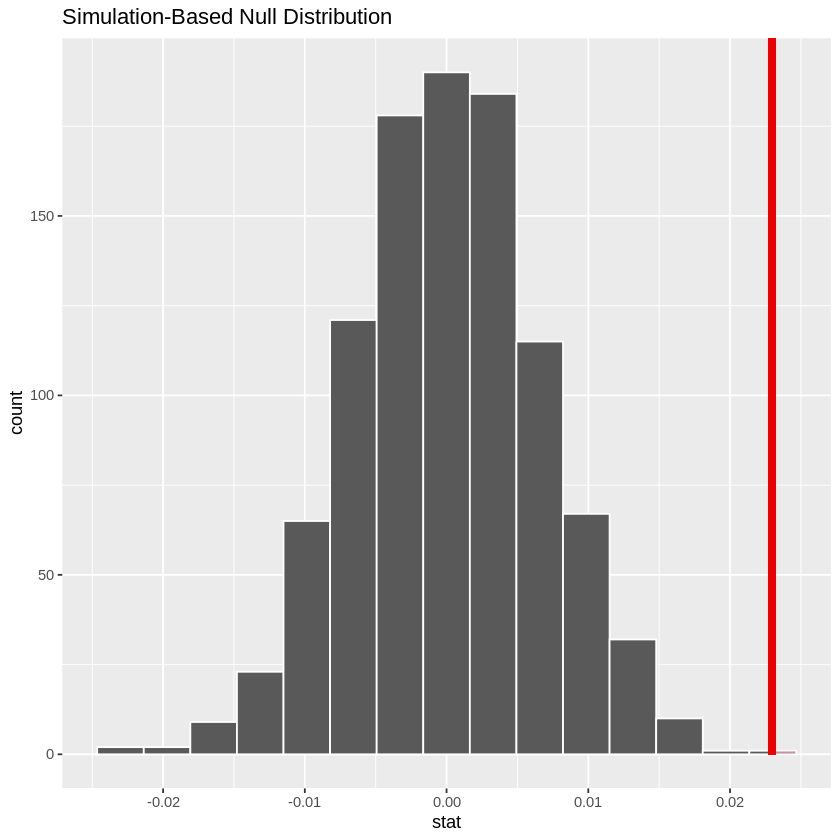

In [ ]:
# visualize the null distribution and the p-value
visualize(nwbv_null_distribution) + 
shade_p_value(obs_stat = obs_diff_mean, direction = "right")

Figure 1.2: Visualization of the null distribution 

> Using simulated-based permutation test of 1000 samples, the p-value appears to be 0. However, we can't report a p-value of 0 as it means there is no possibility of creating a type-I error. The best claim we can make would be p < 0.001 since we used 1000 samples. Consistent with the previous theory-based test, we also reject our null hypothesis that there is no difference between the Nondemented group and the Demented patient group in their Normalized Whole Brain Volume (nWBV) estimate. The Nondemented group seems to have greater nWBV estimate than the demented group.

## Discussion

Summary of results:



## Implication

If we can observe a significant decline in brain volume in Demented patients compared to Non-demented patients, this suggests that similar neuro-imaging techniques can be applicable for detecting biomarkers of AD such as brain volume to aid therapeutic intervention in the future. This is important since there is no definitive formal diagnosis for AD.

This report is trustworthy in three main ways:
1. Hypothesis testing will be performed to examine whether the observed difference is statistically meaningful using a significance level of 5% ($\alpha$ = 0.05 (one-tailed)). We test against the null hypothesis that there is no significant difference in the brain volume of senoir patients with and without signs of Alzheimer's disease. 

2. The dataset collects information from a relatively large sample size (n = 150), which may improves the reliability of our statistical estimate.

3. The report uses bootstrapping to estimate the shape and variability of the sampling distribution to help visualize the reliability of our point estimate. We saw that our standard error estimate for $µ_n - µ_a$ is SE = 0.004, a relatively small figure. This suggests high reliability in the parameter estimate 95%CI (0.0173, 0.031).

We expect to find the demented group to show a statistically significant lower normalized whole brain volume than the non-demented group. 

If a significant decline in the demented group compared to the non-demented group is observed to reject the null-hypothesis, our inferential analysis will suggest brain atrophy in demented patient. This positive finding will not only replicate results of previous studies, but it can also help advance healthcare for patients who show early signs of Alzheimer’s disease (Domoto-Reilly et. al, 2012, Sabuncu et. al, 2011). This can also lead to additional questions about other neurodegenerative diseases as to what kinds of biomarker assessment, treatment, or preventative measures can be taken.


# References

Ash, L. E. (2007). Dementia. On Call Series: On Call Neurology (3rd ed., pp. 401-417), W.B. Saunders.

Dickerson, B. C., Bakkour, A., Salat, D. H., Feczko, E., Pacheco, J., Greve, D. N., Grodstein, F., Wright, C. I., Blacker, D., Rosas, H. D., Sperling, R. A., Atri, A., Growdon, J. H., Hyman, B. T., Morris, J. C., Fischl, B., & Buckner, R. L. (2009). The cortical signature of Alzheimer's disease: regionally specific cortical thinning relates to symptom severity in very mild to mild AD dementia and is detectable in asymptomatic amyloid-positive individuals. Cerebral cortex (New York, N.Y. : 1991), 19(3), 497–510. https://doi.org/10.1093/cercor/bhn113 

Deepak N. (2018). Dementia Classification :Compare Classifiers: Python · MRI and Alzheimers. Kaggle. https://www.kaggle.com/code/deepak525/dementia-classification-compare-classifiers/input

OASIS-2: Longitudinal. (2009). Open Access Series of Imaging Studies. https://doi.org/10.1162/jocn.2009.21407

Reuben, A., Brickman, A., Muraskin, J., Steffener, J., & Stern, Y. (2011). Hippocampal Atrophy Relates to Fluid Intelligence Decline in the Elderly. Journal of the International Neuropsychological Society, 17(1), 56-61. https://doi.org/10.1017/S135561771000127X

Sabuncu, M. R., Desikan, R. S., Sepulcre, J., Yeo, B. T., Liu, H., Schmansky, N. J., Reuter, M., Weiner, M. W., Buckner, R. L., Sperling, R. A., Fischl, B., & Alzheimer's Disease Neuroimaging Initiative (2011). The dynamics of cortical and hippocampal atrophy in Alzheimer disease. Archives of neurology, 68(8), 1040–1048. https://doi.org/10.1001/archneurol.2011.167

